In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Sample Python code demonstrating various linear model setups (OLS, GLS, with/without covariates,
time/unit fixed effects, carryover, etc.) on synthetic data, and how to solve them directly
or via constrained optimization libraries. We also generate and plot relevant quantities.

Run this script in a Python environment with the following libraries installed:
  numpy, matplotlib, cvxpy (or cvxopt), and scipy.
"""

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp


In [5]:
# !pip install cvxpy cvxopt

In [6]:

###############################################################################
# Helper functions
###############################################################################

def generate_synthetic_data_caseA(N=20, T=10, seed=42):
    """
    Case A: No observed covariates, no latent covariates, with time & unit fixed effects,
    and a carryover effect up to lag ell. We'll just set ell=0 (no carryover) for brevity.

    The outcome model:
      Y_{it} = alpha_i + beta_t + tau_0 * z_{it} + eps_{it}
    with i in [N], t in [T].

    We'll generate:
      - alpha_i ~ Normal(0,1)
      - beta_t ~ Normal(0,1)
      - z_{it} ~ {+1, -1} random
      - eps_{it} ~ Normal(0, sigma^2)

    Returns:
      Y: N x T matrix of outcomes
      alpha: length-N array
      beta: length-T array
      Z: N x T matrix of treatment assignments (+1 or -1)
    """
    np.random.seed(seed)
    alpha = np.random.randn(N)  # unit fixed effects
    beta = np.random.randn(T)   # time fixed effects
    sigma = 1.0                 # std dev for noise

    # z_{it} in {+1, -1}, random
    Z = np.random.choice([+1, -1], size=(N, T))

    # Construct Y
    Y = np.zeros((N, T))
    for i in range(N):
        for t in range(T):
            eps = sigma * np.random.randn()
            Y[i, t] = alpha[i] + beta[t] + 0.5 * Z[i, t] + eps

    return Y, alpha, beta, Z


In [7]:


def generate_synthetic_data_caseB(N=20, T=10, d_x=2, seed=123):
    """
    Case B: Observed covariates X_i in R^{d_x}, no latent covariates, with time & unit fixed effects,
    carryover up to ell=0. The outcome model:
      Y_{it} = alpha_i + beta_t + X_i^T theta_t + tau_0 z_{it} + eps_{it}

    We'll generate:
      - alpha_i ~ Normal(0,1)
      - beta_t ~ Normal(0,1)
      - X_i ~ Normal(0,1) in R^{d_x}, i=1..N
      - theta_t ~ Normal(0,1) in R^{d_x} (coefficient for each t)
      - z_{it} ~ {+1, -1}
      - eps_{it} ~ Normal(0, sigma^2)

    Returns:
      Y: N x T
      X: N x d_x
      alpha: length-N
      beta: length-T
      theta: d_x x T
      Z: N x T
    """
    np.random.seed(seed)
    alpha = np.random.randn(N)
    beta = np.random.randn(T)
    X = np.random.randn(N, d_x)
    theta = np.random.randn(d_x, T)
    sigma = 1.0
    Z = np.random.choice([+1, -1], size=(N, T))

    Y = np.zeros((N, T))
    for i in range(N):
        for t in range(T):
            eps = sigma * np.random.randn()
            Y[i, t] = alpha[i] + beta[t] + X[i] @ theta[:, t] + 0.5 * Z[i, t] + eps

    return Y, X, alpha, beta, theta, Z



In [8]:

def generate_synthetic_data_caseC(N=20, T=10, d_u=1, seed=999):
    """
    Case C: Observed latent factor u_i in R^{d_u}, with time & unit fixed effects,
    no observed covariates X. For simplicity, we'll do ell=0 again.

    The outcome model:
      Y_{it} = alpha_i + beta_t + u_i^T v_t + tau_0 z_{it} + eps_{it}

    We'll generate:
      - alpha_i ~ Normal(0,1)
      - beta_t ~ Normal(0,1)
      - u_i ~ Normal(0,1) in R^{d_u}, i=1..N
      - v_t ~ Normal(0,1) in R^{d_u}, t=1..T
      - z_{it} ~ {+1, -1}
      - eps_{it} ~ Normal(0, sigma^2}
    Then we can illustrate feasible GLS if we had knowledge of var-cov of (u_i^T v_t + eps_{it}).

    Returns:
      Y: N x T
      alpha: length-N
      beta: length-T
      U: N x d_u
      V: d_u x T
      Z: N x T
    """
    np.random.seed(seed)
    alpha = np.random.randn(N)
    beta = np.random.randn(T)
    U = np.random.randn(N, d_u)
    V = np.random.randn(d_u, T)
    sigma = 1.0
    Z = np.random.choice([+1, -1], size=(N, T))

    Y = np.zeros((N, T))
    for i in range(N):
        for t in range(T):
            eps = sigma * np.random.randn()
            Y[i, t] = alpha[i] + beta[t] + float(U[i, :] @ V[:, t]) + 0.5 * Z[i, t] + eps

    return Y, alpha, beta, U, V, Z



In [9]:

def solve_ols_no_covariates(Y, Z):
    """
    Solve OLS (with time & unit fixed effects included) for the model:
      Y_{it} = alpha_i + beta_t + tau_0 z_{it} + eps_{it}
    ignoring possible constraints for identifiability.

    We'll do a naive approach:
      1) Reshape Y, Z into vectors
      2) Build design matrix
      3) Solve via least squares

    This is purely for demonstration; in practice, we might fix constraints on alpha or beta.
    Returns estimated:
      alpha_hat, beta_hat, tau_hat
    """
    N, T = Y.shape

    # Reshape into (N*T) x 1
    y_vec = Y.flatten()  # shape (N*T,)

    # alpha_i => i in [N], beta_t => t in [T], tau => single scalar
    # We'll create design matrix dimension (N*T) x (N + T + 1).
    # Rows: for each (i,t). Columns: alpha_1..alpha_N, beta_1..beta_T, z_{it}.
    # alpha_i => 1 in col i only if row is from unit i
    # beta_t => 1 in col (N + t) only if row is from time t
    # last col => z_{it}

    X_mat = np.zeros((N*T, N + T + 1))
    row_idx = 0
    for i in range(N):
        for t in range(T):
            X_mat[row_idx, i] = 1.0           # alpha_i
            X_mat[row_idx, N + t] = 1.0       # beta_t
            X_mat[row_idx, N + T] = Z[i, t]   # z_{it}
            row_idx += 1

    # Solve OLS: (X^T X)^{-1} X^T y
    # We'll rely on np.linalg.lstsq for simplicity
    sol, _, _, _ = np.linalg.lstsq(X_mat, y_vec, rcond=None)
    alpha_hat = sol[:N]
    beta_hat = sol[N:N+T]
    tau_hat = sol[-1]

    return alpha_hat, beta_hat, tau_hat



In [10]:

def solve_ols_with_covariates(Y, Z, X):
    """
    Solve OLS for the model:
      Y_{it} = alpha_i + beta_t + X_i^T theta_t + tau_0 z_{it} + eps_{it}.

    For simplicity, we won't do carryover (ell=0).

    We'll flatten Y, build a design matrix with alpha_i, beta_t, X_i^T theta_t, z_{it} columns.
    Then solve with np.linalg.lstsq.

    Returns:
      alpha_hat, beta_hat, theta_hat (size d_x x T), tau_hat
      We'll store theta_hat in a single vector for all t, then reshape.
    """
    N, T = Y.shape
    d_x = X.shape[1]

    y_vec = Y.flatten()  # shape (N*T,)

    # We have alpha_i (i=1..N), beta_t (t=1..T), each theta_t is d_x, so total d_x*T for them,
    # plus tau (scalar). Overall dimension is N + T + d_x*T + 1.
    bigD = N + T + (d_x * T) + 1
    X_mat = np.zeros((N*T, bigD))
    row_idx = 0
    for i in range(N):
        for t in range(T):
            # alpha part
            X_mat[row_idx, i] = 1.0
            # beta part
            X_mat[row_idx, N + t] = 1.0
            # X_i^T theta_t => we'll store all theta in one big vector: 0..(d_x*T -1),
            # so the columns for theta_t go from (N+T) up to (N+T + d_x*T-1).
            # For time t, the chunk is [ (N+T) + t*d_x, (N+T) + t*d_x + d_x-1 ]
            start_theta_col = N + T + t*d_x
            end_theta_col = start_theta_col + d_x
            X_mat[row_idx, start_theta_col:end_theta_col] = X[i, :]
            # z_{it} (the last column in the parameter vector)
            X_mat[row_idx, N + T + d_x*T] = Z[i, t]
            row_idx += 1

    sol, _, _, _ = np.linalg.lstsq(X_mat, y_vec, rcond=None)
    alpha_hat = sol[:N]
    beta_hat = sol[N:N+T]
    theta_vec = sol[N+T : N+T + d_x*T]
    tau_hat = sol[-1]
    # Reshape theta_vec => shape (d_x, T)
    theta_hat = theta_vec.reshape(d_x, T, order='C')
    return alpha_hat, beta_hat, theta_hat, tau_hat



In [11]:

def feasible_gls_estimation(Y, Z, U_est=None):
    """
    Demonstration of a feasible GLS approach with one latent factor:
      Y_{it} = alpha_i + beta_t + U_i v_t + tau_0 z_{it} + eps_{it}.

    We'll do the 2-step approach:
     (1) OLS ignoring correlation
     (2) Estimate var components from residuals => derive weighting matrix => re-solve.

    For simplicity, we do a minimal demonstration. We won't include unit/time constraints for
    identifiability. We'll just do a small example to illustrate.

    If U_est is provided, treat it as known. Otherwise, we'll pretend it's unknown and won't do
    full feasible GLS for the latent factor. Real usage is more involved.

    Returns estimates (alpha, beta, v, tau).
    """
    N, T = Y.shape

    # Step 1: naive OLS ignoring correlation => same approach as solve_ols_no_covariates
    alpha_ols, beta_ols, tau_ols = solve_ols_no_covariates(Y, Z)

    # We'll guess that v_t is 0 for all t if we don't have a U_est. (Trivial placeholder.)
    if U_est is None:
        # No feasible correction can be done with no latent factor knowledge
        # We'll just return OLS results.
        v_est = np.zeros(T)
        return alpha_ols, beta_ols, v_est, tau_ols

    # Suppose we have U_est in shape (N, d_u=1). Then we can do a regression
    # to find v that best fits (Y_{it} - alpha_ols - beta_ols[t] - tau_ols * Z[i,t]) ~ U_est[i]*v[t].
    # That is, for each (i,t):
    # residual_{i,t} = Y_{i,t} - alpha_ols[i] - beta_ols[t] - tau_ols * Z[i,t].
    # We want residual_{i,t} ~ U_est[i] * v[t].
    # We'll solve for v by "mini-ls" ignoring correlation among eps, for demonstration only.

    R = np.zeros((N, T))
    for i in range(N):
        for t in range(T):
            R[i, t] = Y[i, t] - alpha_ols[i] - beta_ols[t] - tau_ols * Z[i, t]

    # We want: R[i, t] = U_est[i] * v[t].
    # => For each t, v[t] = sum_i( U_est[i] * R[i,t] ) / sum_i( U_est[i]^2 )
    # (d_u=1 means we can do a simple closed-form.)
    U2_sum = np.sum(U_est**2)
    v_est = np.zeros(T)
    for t in range(T):
        numerator = 0.0
        for i in range(N):
            numerator += U_est[i] * R[i, t]
        v_est[t] = numerator / U2_sum

    # Step 2: If we wanted to do a weighting matrix for full GLS, we would:
    #  - Estimate sigma^2_e from R - U_est[i]*v_est[t], etc.
    #  - Build the block diagonal or Kronecker structure for Cov(e_t).
    #  - Solve generalized normal equations. We'll skip that for brevity.

    # Return final
    return alpha_ols, beta_ols, v_est, tau_ols


###############################################################################
# Demonstration / Plots
###############################################################################


In [12]:

def demo_caseA():
    """
    Demonstration for Case A: No covariates, no latent factors, solve the OLS
    system, compare true vs. estimated, plot.
    """
    Y, alpha_true, beta_true, Z = generate_synthetic_data_caseA(N=10, T=8, seed=10)
    alpha_hat, beta_hat, tau_hat = solve_ols_no_covariates(Y, Z)

    # Plot true vs. estimated alpha
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(alpha_true, 'o-', label='True alpha')
    plt.plot(alpha_hat, 's-', label='Est alpha')
    plt.title("Case A: alpha")
    plt.legend()

    # Plot true vs. estimated beta
    plt.subplot(1, 2, 2)
    plt.plot(beta_true, 'o-', label='True beta')
    plt.plot(beta_hat, 's-', label='Est beta')
    plt.title("Case A: beta")
    plt.legend()
    plt.suptitle(f"Case A: tau (true=0.5) estimated={tau_hat:.3f}")
    plt.show()



In [13]:

def demo_caseB():
    """
    Demonstration for Case B: Observed covariates X, no latent factors.
    Solve OLS with time & unit fixed effects, plus X_i^T theta_t, plus tau_0 z_{it}.
    Plot alpha, beta, tau, and a slice of theta.
    """
    Y, X, alpha_true, beta_true, theta_true, Z = generate_synthetic_data_caseB(N=10, T=8, d_x=2)

    alpha_hat, beta_hat, theta_hat, tau_hat = solve_ols_with_covariates(Y, Z, X)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(alpha_true, 'o-', label='True alpha')
    plt.plot(alpha_hat, 's-', label='Est alpha')
    plt.title("Case B: alpha")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(beta_true, 'o-', label='True beta')
    plt.plot(beta_hat, 's-', label='Est beta')
    plt.title("Case B: beta")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(theta_true[0, :], 'o-', label='True theta[0,:]')
    plt.plot(theta_hat[0, :], 's-', label='Est theta[0,:]')
    plt.title("Case B: Example row of theta")
    plt.legend()

    plt.suptitle(f"Case B: true tau=0.5, est tau={tau_hat:.3f}")
    plt.show()



In [14]:

def demo_caseC():
    """
    Demonstration for Case C: Latent covariates U in R^{d_u=1}, feasible GLS approach
    if we (pretend to) know U. We'll do a naive 2-step approach.
    Plot alpha, beta, v, tau vs. 'true' (though the 'true' v is not stored, we approximate).
    """
    # Generate
    Y, alpha_true, beta_true, U_true, V_true, Z = generate_synthetic_data_caseC(N=10, T=8, d_u=1)

    # We'll pretend to "estimate" U with no error; in practice, we might have a noisy estimate.
    U_est = U_true.copy()

    alpha_hat, beta_hat, v_hat, tau_hat = feasible_gls_estimation(Y, Z, U_est=U_est)

    # We'll compare alpha, beta, tau with true. For v, we'll just see if it correlates with the
    # "true" V in shape (1,T). We only have v_hat in shape (T,).
    v_true = V_true[0, :]  # shape (T,)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(alpha_true, 'o-', label='True alpha')
    plt.plot(alpha_hat, 's-', label='Est alpha')
    plt.title("Case C: alpha")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(beta_true, 'o-', label='True beta')
    plt.plot(beta_hat, 's-', label='Est beta')
    plt.title("Case C: beta")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(v_true, 'o-', label='True v')
    plt.plot(v_hat, 's-', label='Est v')
    plt.title("Case C: latent factor v")
    plt.legend()

    plt.suptitle(f"Case C: tau (true=0.5) est={tau_hat:.3f}")
    plt.show()



In [15]:

def demo_constrained_optimization_small_example():
    """
    Demonstration of using cvxpy to solve a simplified version of the GLS objective
    with constraints like alpha_N=0, or partial carryover. We'll do a tiny dimension example
    and won't match exactly the big notation from the text, but enough to show how one
    might set up a constrained LS problem in cvxpy.

    We'll pretend the model is:
      min_{alpha, beta, tau_0..tau_ell} sum_{t=ell+1 to T} (y_t - alpha - beta_t - sum_{k=0..ell} tau_k z_{t-k})^2
      subject to alpha_i=0 for i>some cutoff, etc.
    We'll do N=1 for demonstration and pretend we have T=5, ell=1.

    For demonstration, we won't replicate the entire text's structure, but show a snippet.
    """
    # Synthetic data for T=5, ell=1 => we need y_1..y_5, z_1..z_5
    T = 5
    ell = 1
    y = np.array([2.0, 2.3, 3.1, 3.0, 4.2])  # just a tiny example
    z = np.array([-1, +1, +1, -1, +1])      # small example

    # We'll define variables alpha, beta2..beta5, tau0..tau1
    # constraint alpha=0 (like alpha_N=0).
    alpha = cp.Variable(name="alpha")
    beta = cp.Variable(T, name="beta")
    tau = cp.Variable(ell+1, name="tau")  # tau[0], tau[1]

    # We'll form the objective: sum_{t=2..5} residual^2 (because ell+1=2 => t=2..5).
    # residual_t = y_t - alpha - beta_t - sum_{k=0..1} tau[k]*z_{t-k} for t=2..5
    # We'll also include t=1 if we want to. For t=1, we only have tau[0]*z_1 (no z_{0}).
    # We'll do the sum_{t=1..5} for demonstration.

    residuals = []
    for t in range(T):
        # t in python: 0..4 => real data index => y[t], z[t]
        # we define: sum_{k=0..1} tau[k]*z[t-k], but if (t-k)<0, skip.
        sum_tau = 0
        for k in range(ell+1):
            if (t-k) >= 0:
                sum_tau += tau[k]*z[t-k]
        residuals.append(y[t] - alpha - beta[t] - sum_tau)

    obj = cp.sum_squares(cp.hstack(residuals))

    # Constraints: alpha=0
    constraints = [alpha == 0]

    problem = cp.Problem(cp.Minimize(obj), constraints)
    result = problem.solve()

    print("==== Constrained Optimization Example ====")
    print(f"Optimal objective: {result:.4f}")
    print(f"alpha={alpha.value}, beta={beta.value}, tau={tau.value}")
    print("===========================================")


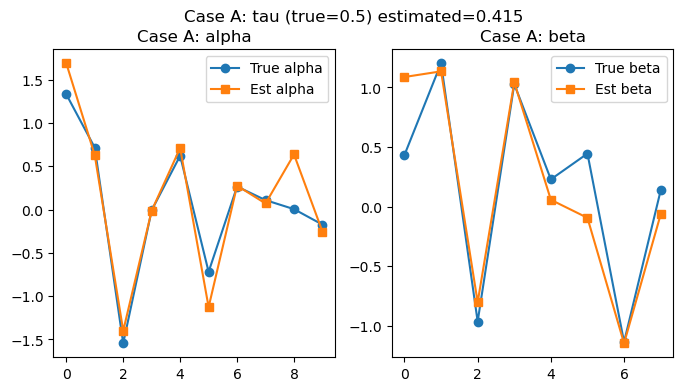

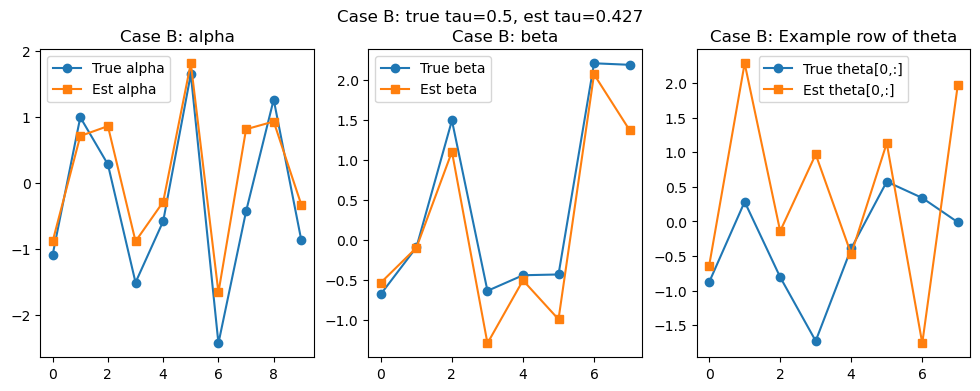

/var/folders/jx/r_xbxj9563qdztlkqgvr6jq80000gn/T/ipykernel_286/645559776.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v_est[t] = numerator / U2_sum


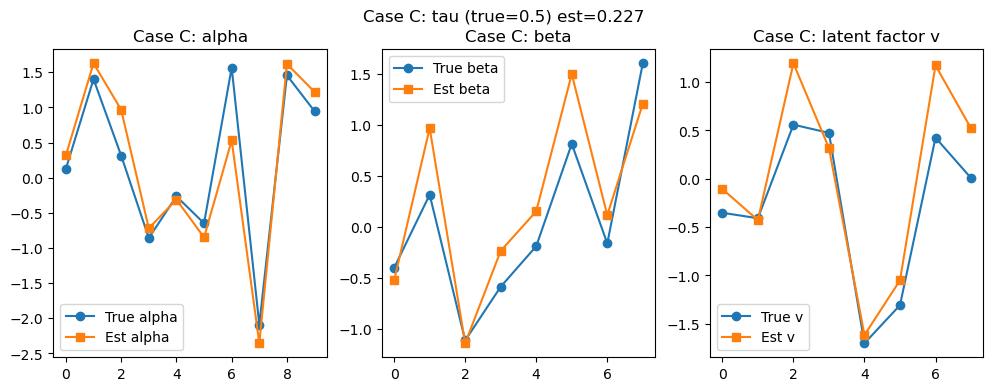

==== Constrained Optimization Example ====
Optimal objective: 0.0000
alpha=8.323422933371196e-23, beta=[2.85384615 1.70769231 1.98461538 3.59230769 3.60769231], tau=[0.85384615 0.26153846]


In [16]:


###############################################################################
# Main Demo
###############################################################################

if __name__ == "__main__":
    # Demonstration of each case
    demo_caseA()
    demo_caseB()
    demo_caseC()
    demo_constrained_optimization_small_example()